In [4]:
from IPython.display import clear_output
import time 

!pip install transformers
!pip install seaborn

time.sleep(5)
clear_output(wait=False)

In [5]:
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00",
                        "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8,6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
time.sleep(5)
clear_output(wait=False)

In [12]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [13]:
df.shape

(15746, 11)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/ssd003/projects/aieng/conversational_ai/envs/stable_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='count'>

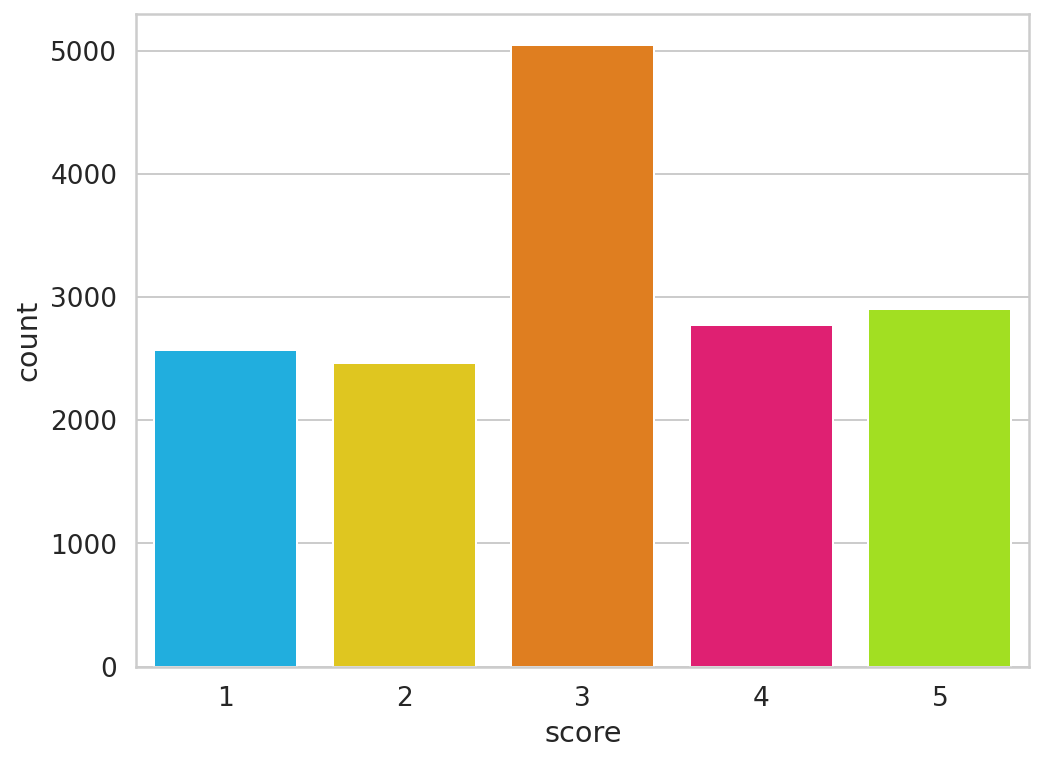

In [17]:
sns.countplot(df.score)

In [18]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <=2:
        return 0
    elif rating ==3:
        return 1
    else:
        return 2

In [19]:
df['sentiment'] = df.score.apply(to_sentiment)

/ssd003/projects/aieng/conversational_ai/envs/stable_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

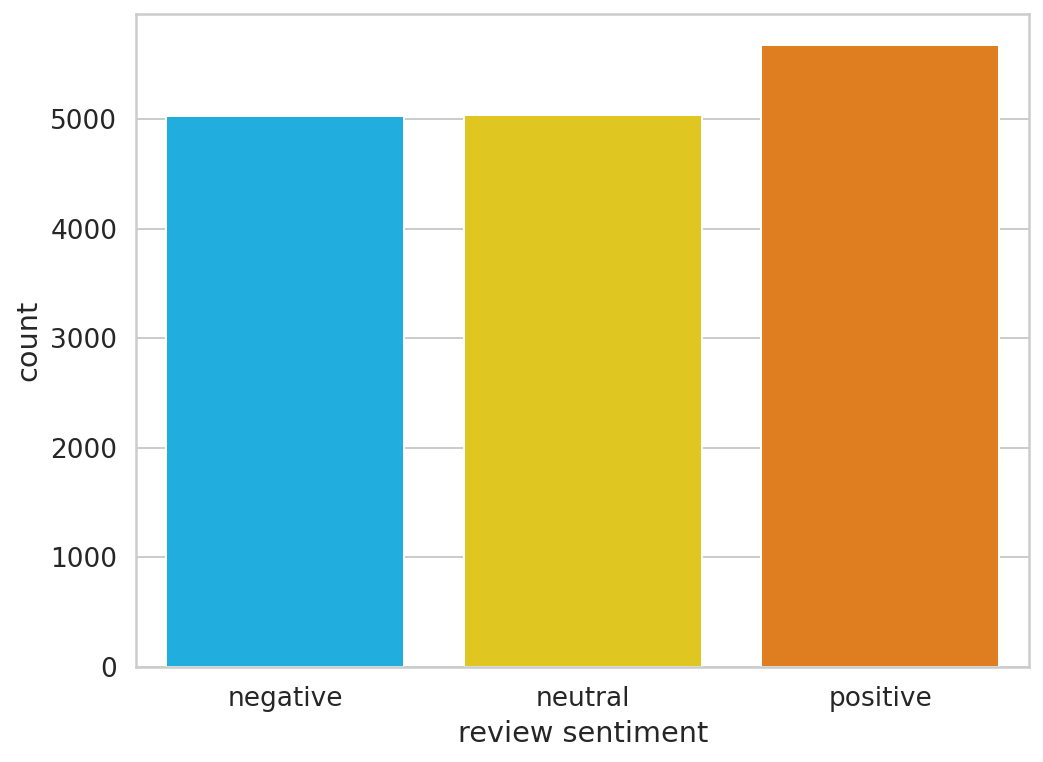

In [21]:
ax = sns.countplot(df.sentiment)
class_names = ['negative', 'neutral', 'positive']
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

### Data Preprocessing

In [22]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
sample_txt = "The quick brown fox jumped over the lazy dog."
tokens = tokenizer.tokenize(sample_txt)
print(len(tokens))
print(tokens)

10
['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.']


In [26]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids))
print(token_ids)

10
[1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 1012]


In [33]:
# Special tokens
print(f'Separation token: {tokenizer.sep_token}, ID: {tokenizer.sep_token_id}')
print(f'Classification token: {tokenizer.cls_token}, ID: {tokenizer.cls_token_id}')
print(f'Padding token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}')
print(f'Unknown token: {tokenizer.unk_token}, ID: {tokenizer.unk_token_id}')


Separation token: [SEP], ID: 102
Classification token: [CLS], ID: 101
Padding token: [PAD], ID: 0
Unknown token: [UNK], ID: 100


In [38]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [45]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'])

32
tensor([[  101,  1996,  4248,  2829,  4419,  5598,  2058,  1996, 13971,  3899,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])


In [46]:
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

32
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [47]:
# See data length distribution to choose seq length
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

/ssd003/projects/aieng/conversational_ai/envs/stable_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

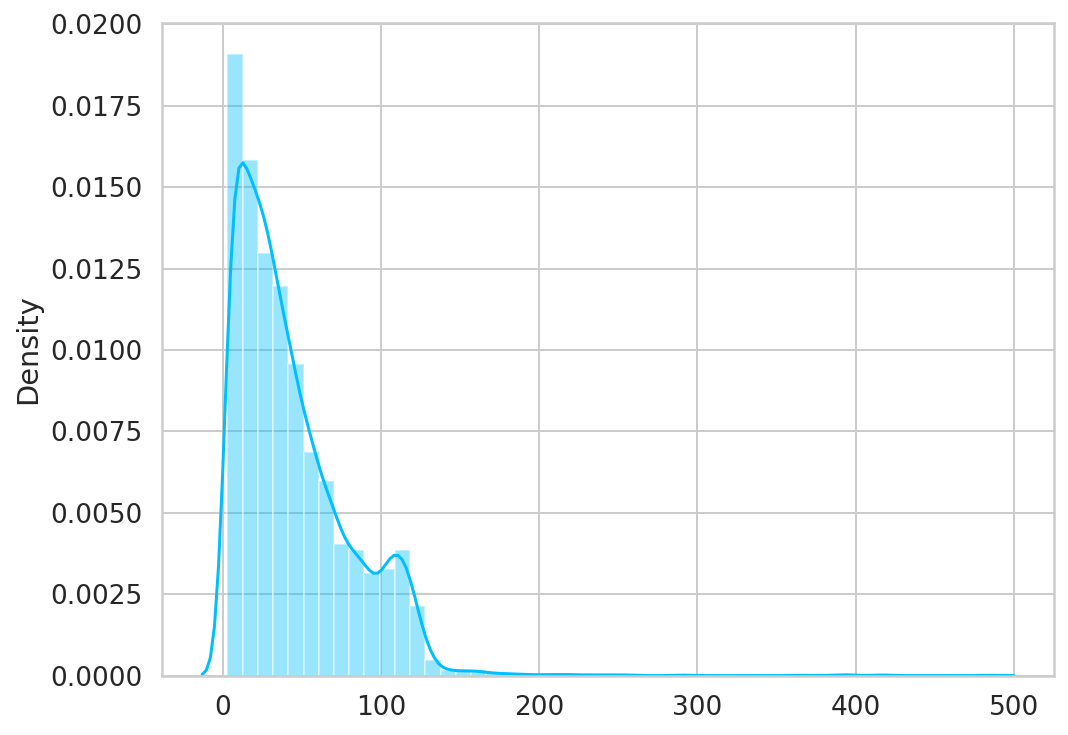

In [48]:
sns.distplot(token_lens)

### Dataset

In [65]:
class GPReviewDataset(data.Dataset):
    
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        
        encoding = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [66]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20

In [67]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [68]:
df_train.shape, df_val.shape, df_test.shape

((12596, 12), (1575, 12), (1575, 12))

In [71]:
def create_dataloader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [72]:
train_dataloader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [73]:
data = next(iter(train_dataloader))
data.keys()

/ssd003/projects/aieng/conversational_ai/envs/stable_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/ssd003/projects/aieng/conversational_ai/envs/stable_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

dict_keys(['input_ids', 'attention_mask', 'targets'])